# Boston House Pricing Prediction
* Evaluation metric is Root Mean Square Error!

In [1]:
import pandas as pd
import numpy as np
import math

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# feature selection
from sklearn.feature_selection import RFECV

# pipeline
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import mean_squared_error

# LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Neighbors
from sklearn.neighbors import KNeighborsRegressor

# Clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# t-SNE
from sklearn.manifold import TSNE

# PCA
from sklearn.decomposition import PCA

In [2]:
train_df = pd.read_csv('./train.csv', index_col='ID')
test_df = pd.read_csv('./test.csv', index_col='ID')

### Let's see what the columns are like

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 1 to 506
Data columns (total 14 columns):
crim       333 non-null float64
zn         333 non-null float64
indus      333 non-null float64
chas       333 non-null int64
nox        333 non-null float64
rm         333 non-null float64
age        333 non-null float64
dis        333 non-null float64
rad        333 non-null int64
tax        333 non-null int64
ptratio    333 non-null float64
black      333 non-null float64
lstat      333 non-null float64
medv       333 non-null float64
dtypes: float64(11), int64(3)
memory usage: 39.0 KB


### Let's get some summary statistics

In [4]:
train_df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,3.360341,10.689189,11.293483,0.060060,0.557144,6.265619,68.226426,3.709934,9.633634,409.279279,18.448048,359.466096,12.515435,22.768769
std,7.352272,22.674762,6.998123,0.237956,0.114955,0.703952,28.133344,1.981123,8.742174,170.841988,2.151821,86.584567,7.067781,9.173468
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,6.000000,1.129600,1.000000,188.000000,12.600000,3.500000,1.730000,5.000000
25%,0.078960,0.000000,5.130000,0.000000,0.453000,5.884000,45.400000,2.122400,4.000000,279.000000,17.400000,376.730000,7.180000,17.400000
50%,0.261690,0.000000,9.900000,0.000000,0.538000,6.202000,76.700000,3.092300,5.000000,330.000000,19.000000,392.050000,10.970000,21.600000
75%,3.678220,12.500000,18.100000,0.000000,0.631000,6.595000,93.800000,5.116700,24.000000,666.000000,20.200000,396.240000,16.420000,25.000000
max,73.534100,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,21.200000,396.900000,37.970000,50.000000


* let's scale this data between 0 and 1

In [5]:
train_df.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
11,0.22489,12.5,7.87,0,0.524,6.377,94.3,6.3467,5,311,15.2,392.52,20.45,15.0
12,0.11747,12.5,7.87,0,0.524,6.009,82.9,6.2267,5,311,15.2,396.90,13.27,18.9
13,0.09378,12.5,7.87,0,0.524,5.889,39.0,5.4509,5,311,15.2,390.50,15.71,21.7
14,0.62976,0.0,8.14,0,0.538,5.949,61.8,4.7075,4,307,21.0,396.90,8.26,20.4


## Let's start building a pipeline

In [6]:
#train_df['zn'] = train_df['zn'].apply(lambda x: max(0, x))
# normalize data
crim = stats.boxcox(train_df['crim'])
zn = train_df['zn']
indus = stats.boxcox(train_df['indus'])
chas = train_df['chas']
nox = stats.boxcox(train_df['nox'])
rm = stats.boxcox(train_df['rm'])
age = stats.boxcox(train_df['age'])
dis = stats.boxcox(train_df['dis'])
rad = stats.boxcox(train_df['rad'])
tax = stats.boxcox(train_df['tax'])
ptratio = stats.boxcox(train_df['ptratio'])
black = stats.boxcox(train_df['black'])
lstat = stats.boxcox(train_df['lstat'])

In [7]:
'''
# For KNeighborsRegressor
predictors = pd.DataFrame({
    'crim': crim[0],
    'indus': indus[0],
    'nox': nox[0],
    'rm': rm[0],
    'age': age[0],
    'dis': dis[0],
    'rad': rad[0],
    'tax': tax[0],
    'ptratio': ptratio[0],
    'black': black[0],
    'lstat': lstat[0]
})
'''

use_cols = ['chas', 'nox', 'rm', 'dis', 'ptratio', 'lstat']
#predictors = train_df.drop('medv', axis=1)
predictors = train_df[use_cols]
target = train_df['medv']
print(predictors.shape)
print(target.shape)


(333, 6)
(333,)


In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3)

In [9]:
print(X_train.shape)
print(y_train.shape)

(233, 6)
(233,)


In [10]:
steps = [
    ('scaler', MinMaxScaler()),
    ('model', KNeighborsRegressor())
]
pipeline = Pipeline(steps)


# For KNeighborsRegressor
parameters = {
    'model__n_neighbors': [1, 3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2, 3]
}

'''
parameters = {
    'model__alpha': [0.1, 0.5, 0.6, 0.7, 2, 4],
    'model__normalize': [False, True]
}
'''

"\nparameters = {\n    'model__alpha': [0.1, 0.5, 0.6, 0.7, 2, 4],\n    'model__normalize': [False, True]\n}\n"

In [11]:
model = GridSearchCV(pipeline, param_grid=parameters)
model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__n_neighbors': [1, 3, 5, 7, 9], 'model__weights': ['uniform', 'distance'], 'model__p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
y_pred = model.predict(X_test)

In [13]:
print('Model Score {}'.format(model.score(X_test, y_test)))

Model Score 0.7164839027244055


In [14]:
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print('Model MSE {}'.format(mse))
print('Model RMSE {}'.format(math.sqrt(mse)))

Model MSE [17.82174703]
Model RMSE 4.221581105047514


In [15]:
print(model.best_params_)

{'model__n_neighbors': 5, 'model__p': 1, 'model__weights': 'distance'}


### Before Scaling w/ LinearRegression
* Model MSE [26.33836965]
* Model RMSE 5.13209213217005

### After Scaling w/ LinearRegression
* Model MSE [18.31814198]
* Model RMSE 4.279969857410528
* At this point we would be somewhere around number 52 on the Leaderboard

## After Normalizing, Scaling w/ KNeighborsRegressor
* Model MSE [16.48735365]
* Model RMSE 4.060462245488985

## Need to improve.
### Inspect feature dependencies

In [16]:
# model coefficients
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X_train)
lr = LinearRegression()
lr.fit(scaled, y_train)
test_scaled = scaler.transform(X_test)
y_pred = lr.predict(scaler.transform(test_scaled))

In [17]:
print('LR Score: {}'.format(lr.score(test_scaled, y_test)))

LR Score: 0.5964980567448761


In [18]:
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print('Model MSE {}'.format(mse))
print('Model RMSE {}'.format(math.sqrt(mse)))

Model MSE [45.26810012]
Model RMSE 6.7281572603061255


In [19]:
print(lr.coef_)

[  4.81243141  -9.11200371  25.60379667 -11.62334782  -7.71709178
 -18.79811917]


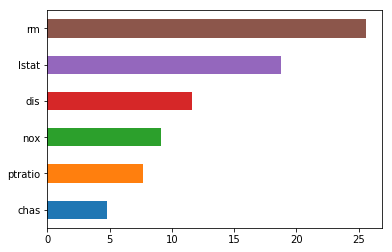

In [20]:
coefficients = lr.coef_
feature_importance = pd.Series(coefficients, index=predictors.columns)
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

In [21]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

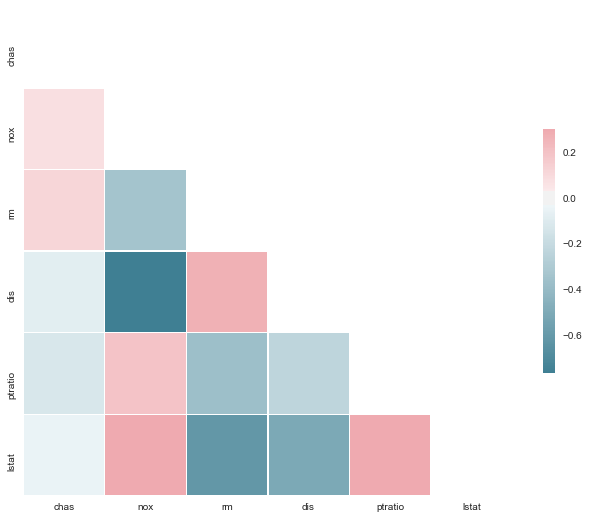

In [22]:
plot_correlation_heatmap(predictors)

In [23]:
lr = LinearRegression()
selector = RFECV(lr,cv=10)
selector.fit(predictors,target)

RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [24]:
optimized_columns = predictors.columns[selector.support_]
print(optimized_columns)

Index(['chas', 'nox', 'rm', 'dis', 'ptratio', 'lstat'], dtype='object')


In [25]:
predictors_2 = predictors[optimized_columns]

X_train, X_test, y_train, y_test = train_test_split(predictors_2, target, test_size=0.3)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X_train)
lr = LinearRegression()
lr.fit(scaled, y_train)
test_scaled = scaler.transform(X_test)
y_pred = lr.predict(scaler.transform(test_scaled))

print('LR Score: {}'.format(lr.score(test_scaled, y_test)))

mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print('Model MSE {}'.format(mse))
print('Model RMSE {}'.format(math.sqrt(mse)))

LR Score: 0.654052059976508
Model MSE [79.26928217]
Model RMSE 8.903329836041618


## What shape do we get from Scatter Plots?

['chas', 'nox', 'rm', 'dis', 'ptratio', 'lstat']

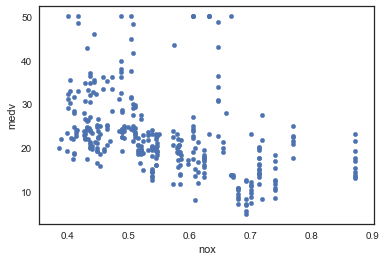

In [38]:
train_df[['nox', 'medv']].plot(kind='scatter', x='nox', y='medv')

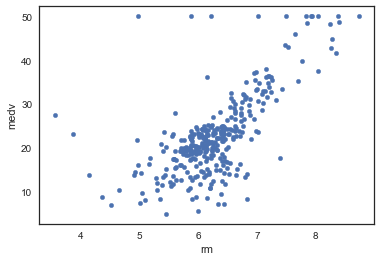

In [39]:
train_df[['rm', 'medv']].plot(kind='scatter', x='rm', y='medv')

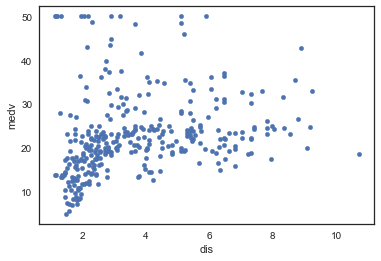

In [40]:
train_df[['dis', 'medv']].plot(kind='scatter', x='dis', y='medv')

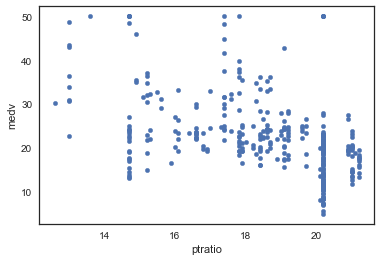

In [41]:
train_df[['ptratio', 'medv']].plot(kind='scatter', x='ptratio', y='medv')

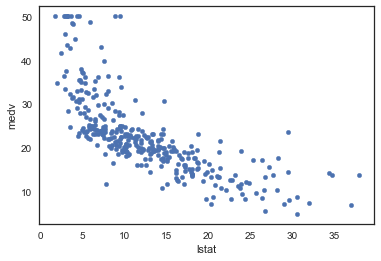

In [42]:
train_df[['lstat', 'medv']].plot(kind='scatter', x='lstat', y='medv')

## t-distributed Stochastic Neighborhood Embeddings

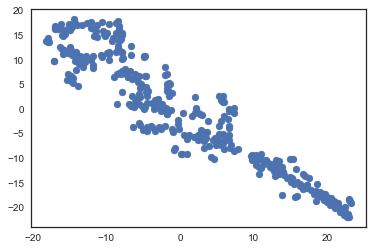

In [26]:
model_t = TSNE(learning_rate=200)
transformed = model_t.fit_transform(predictors)
xs = transformed[:, 0]
ys = transformed[:, 1]
plt.scatter(xs, ys)
plt.show()

**if we dropped outliers from our training data, would it help?**

## PCA

In [27]:
# introduce interaction features


In [28]:
model_p = PCA(n_components=2)
model_p.fit(predictors)
transformed = model_p.transform(predictors)

In [29]:
features = range(model_p.n_components_)
variances = model_p.explained_variance_

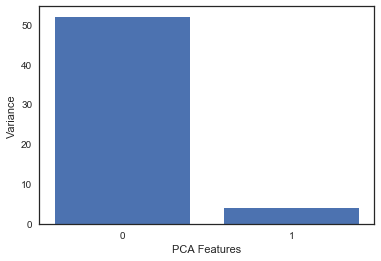

In [30]:
plt.bar(features, variances)
plt.xticks(features)
plt.xlabel('PCA Features')
plt.ylabel('Variance')
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(transformed, target, test_size=0.3)

In [32]:
p = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])
p.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [33]:
y_pred = p.predict(X_test)

In [34]:
print('Model Score {}'.format(p.score(X_test, y_test)))

Model Score 0.5350579611907937


In [35]:
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print('Model MSE {}'.format(mse))
print('Model RMSE {}'.format(math.sqrt(mse)))

Model MSE [36.86622645]
Model RMSE 6.071756455177128
